In [1]:
from river import stream,tree,metrics
import utils
import datetime
from encoding import prefix_bin
import csv

In [2]:
dataset = stream.iter_csv(
            './data/BPIC15_streaming.csv',
            )
totallength = len(list(dataset))

In [5]:
dataset = stream.iter_csv(
            './data/BPIC15_streaming.csv',
            
            )

In [4]:
key_pair = {
    'Case ID' : 'caseid',
    'Activity' : 'activity',
    'Resource' : 'resource',
    'Complete Timestamp' : 'ts'
}

case_dict ={}
trainset_prefix ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}

acc_dict ={}

In [ ]:
def set_label(x):
    

In [5]:
for x,y in dataset:
    if rowcounter%1000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)

    # Event timestamp slice decimals
#     x['ts'] = x['ts'][:-4]

    # Check label possible
    x = utils.set_label(x)

    # Initialize case by prefix length
    caseid = x['caseid']
    x.pop('caseid')
    case_bin = prefix_bin(caseid, x)

    # Allocate event stream to prefix bin class
    if 'True label' not in x.keys():
        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])
        case_bin.update_encoded()
        case_dict[caseid].append(case_bin)

    # Adding newly finished case to training set.    
    else:
        casecount +=1

        # Grace period to collect feature matrix
        if casecount <100:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    trainset_prefix['prefix_%s'%(prefix+1)] = [tree.HoeffdingAdaptiveTreeClassifier(grace_period=50,split_criterion='info_gain'),metrics.Accuracy(), 0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            case_dict.pop(caseid)               

        # Real training start
        else:
            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            y = x['True label']
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                if case_dict[caseid][prefix].grace_updated == False:
                    case_dict[caseid][prefix].encoded = utils.readjustment_training(case_dict[caseid][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                case_dict[caseid][prefix].update_grace_status(True)
                x = case_dict[caseid][prefix].encoded
                model = trainset_prefix['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                trainset_prefix['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                trainset_prefix['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        if case_dict[cases][prefix].grace_updated ==False:
                            case_dict[cases][prefix].encoded = utils.readjustment_training(case_dict[cases][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])

                        case_dict[cases][prefix].update_grace_status(True)
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        case_dict[cases][prefix].update_prediction((trainset_prefix['prefix_%s'%(prefix+1)][2], y_pred))
            resultdict[caseid] = case_dict.pop(caseid)

    if casecount > 200 and rowcounter%1000 == 0:
        for prefix in trainset_prefix.keys():
            model = trainset_prefix[prefix][0]
            if prefix not in list(acc_dict.keys()):
                acc_dict[prefix]=[trainset_prefix[prefix][1].get()]
            else:
                acc_dict[prefix].append(trainset_prefix[prefix][1].get())
            outputfile = './%s/%s.png'%(prefix, round(rowcounter*100/totallength,2))
            utils.save_graph_as_png(model.draw(),outputfile)


0.0 % Case finished: 0
4.46 % Case finished: 22
8.92 % Case finished: 47
13.39 % Case finished: 110
17.85 % Case finished: 244
22.31 % Case finished: 362
26.77 % Case finished: 503
31.24 % Case finished: 686
35.7 % Case finished: 820
40.16 % Case finished: 974
44.62 % Case finished: 1008
49.09 % Case finished: 1081
53.55 % Case finished: 1203
58.01 % Case finished: 1373
62.47 % Case finished: 1584
66.94 % Case finished: 1744
71.4 % Case finished: 1910
75.86 % Case finished: 2132
80.32 % Case finished: 2273
84.79 % Case finished: 2469
89.25 % Case finished: 2953
93.71 % Case finished: 3711
98.17 % Case finished: 4599


In [6]:
for prefix in acc_dict.keys():
    print(acc_dict[prefix])

[0.496551724137931, 0.5285171102661597, 0.5371287128712872, 0.5741056218057922, 0.5728155339805825, 0.5668571428571428, 0.5698569856985699, 0.5580448065173116, 0.5461956521739131, 0.5290423861852434, 0.5245791245791246, 0.5300911854103344, 0.526228602981778, 0.5228726020659125, 0.5220791168353266, 0.5270042194092827, 0.5262789067974772, 0.5359911406423035, 0.6002222222222222]
[0.5547445255474452, 0.5766129032258065, 0.577023498694517, 0.6103202846975089, 0.6111111111111112, 0.6004784688995215, 0.6022988505747127, 0.5899893503727369, 0.5767045454545454, 0.556920556920557, 0.5474349964862966, 0.5351934051997463, 0.5305299539170507, 0.5407483341875962, 0.5459330143540669, 0.5471698113207547, 0.5451250453062704, 0.5538461538461539, 0.6149988602689765]
[0.875, 0.8359788359788359, 0.8054607508532423, 0.8183908045977012, 0.8150943396226416, 0.8021806853582555, 0.8026905829596412, 0.7997179125528914, 0.7923566878980892, 0.7804054054054054, 0.780295566502463, 0.7799263351749539, 0.7761069340016

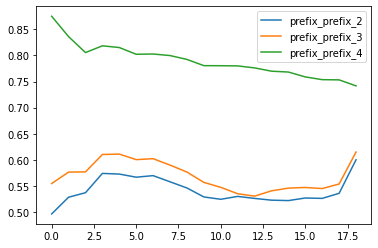

In [7]:
import matplotlib.pyplot as plt
for prefix in acc_dict.keys():
    plt.plot(range(len(acc_dict[prefix])), acc_dict[prefix],label='prefix_%s'%(prefix))
plt.legend()
plt.show()

In [11]:
print(set(resultdict['Offer_1177178664'][1].predicted.values()))
print(set(resultdict['Offer_1177178664'][2].predicted.values()))
print(set(resultdict['Offer_1510165732'][3].predicted.values()))

print(resultdict['Offer_1510165732'][1].true_label)


for case in np.random.choice(list(resultdict.keys()),5):
    try:
        print(set(resultdict[case][3].predicted.values()))
        print(resultdict[case][3].true_label)    
    except:
        pass

{'Accepted', 'Not accepted'}
{'Accepted', 'Not accepted'}
{'Accepted'}
Accepted
{'Accepted'}
Accepted
{'Accepted'}
Accepted
{'Accepted'}
Not accepted
{'Accepted'}
Not accepted
{'Accepted'}
Not accepted


In [9]:
print(trainset_prefix)

{'prefix_2': [HoeffdingAdaptiveTreeClassifier (
  grace_period=50
  max_depth=inf
  split_criterion="info_gain"
  split_confidence=1e-07
  tie_threshold=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  attr_obs="gaussian"
  attr_obs_params={}
  bootstrap_sampling=True
  drift_window_threshold=300
  adwin_confidence=0.002
  seed=None
), Accuracy: 61.97%, 4901], 'prefix_3': [HoeffdingAdaptiveTreeClassifier (
  grace_period=50
  max_depth=inf
  split_criterion="info_gain"
  split_confidence=1e-07
  tie_threshold=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  attr_obs="gaussian"
  attr_obs_params={}
  bootstrap_sampling=True
  drift_window_threshold=300
  adwin_confidence=0.002
  seed=None
), Accuracy: 63.35%, 4786], 'prefix_4': [HoeffdingAdaptiveTreeClassifier (
  grace_period=50
  max_depth=inf
  split_criterion="info_gain"
  split_confidence=1e-07
  tie_threshold=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
 

In [10]:
import numpy as np
testcases =[]
testpred = []
testtrue = []
for cases in (np.random.choice(list(resultdict.keys()), 1500)):
    if len(resultdict[cases])>3:
        y_pred = trainset_prefix['prefix_4'][0].predict_one(resultdict[cases][3].encoded)
        testpred.append(y_pred)
        testtrue.append(resultdict[cases][3].true_label)
metric = metrics.Accuracy()
cm = metrics.ConfusionMatrix()
report = metrics.ClassificationReport()
for yt,yp in zip(testtrue,testpred):
    metric = metric.update(yt,yp)
    cm = cm.update(yt,yp)
    report = report.update(yt,yp)
print(metric)
print(cm)
print(report)

Accuracy: 71.52%
                    Accepted  Not accepted
      Accepted           540             0
  Not accepted           215             0
               Precision   Recall   F1      Support  
                                                     
    Accepted       0.715    1.000   0.834        54  
Not accepted       0.000    0.000   0.000       215  
                                                     
       Macro       0.358    0.500   0.417            
       Micro       0.715    0.715   0.715            
    Weighted       0.512    0.715   0.596            

                   71.5% accuracy                    
